In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def resolveTS(A,b): #A Triangular Superior
    x = np.zeros(len(A))
    for i in range(len(A)-1,-1,-1):
        x[i] = (b[i] - (A[i][i+1:]*x[i+1:]).sum())/A[i][i]
    return x

def resolveTI(A,b): #A Triangular Inferior
    x = np.zeros(len(b))
    for i in range(len(b)):
        x[i] = (b[i] - (A[i][:i]*x[:i]).sum())/A[i][i] # x[<intervalo_fechado>:<intervalo_aberto>]
    return x

def decompoeLU(A):
    L = np.identity(len(A))
    U = A.copy()
    for i in range(len(A)-1):
        L[i+1:,i] = U[i+1:,i]/U[i][i]
        U[i+1:] -= L[i+1:,i].reshape((len(L[i+1:]),1))*U[i]
    return L,U 

def resolveLU(L,U,b):
    y = resolveTI(L,b)
    return resolveTS(U,y)

def verificaCholesky(A):
    return (A == A.T).all() and (A.diagonal() > 0).all() and (np.linalg.eig(A)[0] > 0).all() and verificaPivot(A)

def geraCholesky(A):
    L = np.zeros(A.shape)
    for j in range(len(A)):
        L[j][j] = np.sqrt(A[j][j] - (np.power(L[j][:j],2).sum()))
        for i in range(len(A)):
            L[i,j] = (A[i,j]- (L[i,:j]*L[j,:j]).sum())/L[j,j]
    j = len(A)-1
    L[j,j] = np.sqrt(A[j,j]-(L[j][:j]**2).sum())
    return L

def cholesky(A,b):
    L = geraCholesky(A)
    return resolveLU(L,L.T,b)

def regressaoLinear(x,y):
    A = np.zeros((2,2))
    b = np.zeros(2)
    A[0,0] = len(x)
    A[0,1] = A[1,0] = x.sum()
    A[1,1] = (x*x).sum()
    b[0] = y.sum()
    b[1] = (x*y).sum()
    return cholesky(A,b) # np.linalg.solve(A,b) - Eliminação Gaussiana no Numpy

def regressaoLinearMultipla(x,y): #x é uma matriz ao invés de vetor
    xs = np.vstack((np.ones(len(x[0])),x))
    ys = xs.dot(y)
    xs = xs.dot(xs.T)
    return cholesky(xs,ys)

def resolveLin(b,x):
    return b[0] + (b[1:]*x)

def resolveLinVet(b,x):
    return b[0] + (b[1:]*x).sum(axis=1)

def distanciaquad(y,ypred):
    return ((y-ypred)**2).sum()
    
def r2(y,ypred):
    return 1 - distanciaquad(y,ypred)/((y-y.mean())**2).sum()

In [3]:
base = pd.read_csv("MICRODADOS_ENEM_ESCOLA.csv",delimiter=',',encoding="utf-8")

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,8,9,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
base.tail()

,NU_ANO,CO_UF_ESCOLA,SG_UF_ESCOLA,CO_MUNICIPIO_ESCOLA,NO_MUNICIPIO_ESCOLA,CO_ESCOLA_EDUCACENSO,NO_ESCOLA_EDUCACENSO,TP_DEPENDENCIA_ADM_ESCOLA,TP_LOCALIZACAO_ESCOLA,NU_MATRICULAS,...,INSE,PC_FORMACAO_DOCENTE,NU_TAXA_PERMANENCIA,NU_TAXA_APROVACAO,NU_TAXA_REPROVACAO,NU_TAXA_ABANDONO,PORTE_ESCOLA,Unnamed: 27,Unnamed: 28,Unnamed: 29
172300,2013,53,DF,5300108,Bras�lia,53068181,CED 310 DE SANTA MARIA,2,1,213,...,NaN,91.8,NaN,83.1,9.1,7.8,Maior que 90 alunos,NaN,NaN,NaN
172301,2014,53,DF,5300108,Bras�lia,53068181,CED 310 DE SANTA MARIA,2,1,138,...,NaN,72.0,82.00,81.2,17.5,1.3,Maior que 90 alunos,NaN,NaN,NaN
172302,2015,53,DF,5300108,Bras�lia,53068181,CED 310 DE SANTA MARIA,2,1,198,...,Grupo 3,83.3,76.32,78.9,10.1,11.0,Maior que 90 alunos,NaN,NaN,NaN
172303,2014,53,DF,5300108,Bras�lia,53082001,COL IMPACTO,4,1,12,...,NaN,69.2,NaN,91.4,8.6,0.0,De 1 a 30 alunos,NaN,NaN,NaN
172304,2015,53,DF,5300108,Bras�lia,53082001,COL IMPACTO,4,1,28,...,Grupo 5,57.1,75.00,95.0,5.0,0.0,De 1 a 30 alunos,NaN,NaN,NaN


In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172305 entries, 0 to 172304
Data columns (total 30 columns):
NU_ANO                       172305 non-null int64
CO_UF_ESCOLA                 172305 non-null int64
SG_UF_ESCOLA                 172305 non-null object
CO_MUNICIPIO_ESCOLA          172305 non-null int64
NO_MUNICIPIO_ESCOLA          172305 non-null object
CO_ESCOLA_EDUCACENSO         172305 non-null int64
NO_ESCOLA_EDUCACENSO         172305 non-null object
TP_DEPENDENCIA_ADM_ESCOLA    172302 non-null object
TP_LOCALIZACAO_ESCOLA        172305 non-null object
NU_MATRICULAS                172305 non-null object
NU_PARTICIPANTES_NEC_ESP     48226 non-null float64
NU_PARTICIPANTES             169454 non-null float64
NU_TAXA_PARTICIPACAO         107539 non-null float64
NU_MEDIA_CN                  104706 non-null float64
NU_MEDIA_CH                  104688 non-null float64
NU_MEDIA_LP                  104687 non-null float64
NU_MEDIA_MT                  104687 non-null float64
NU_

In [6]:
for c in base.columns:
    if c[:2] == 'CO' or c[:2] == 'Un':
        base.drop(c,axis=1,inplace=True)

In [7]:
base.columns = ['Ano','UF','Municipio','Escola','Dependencia_ADM','Localizacao','Matriculas','Participantes_PCD','Participantes','Taxa_Participacao','Media_Naturais','Media_Humanas','Media_Linguagens','Media_Matematica','Media_Redacao','Media_ProvaObjetiva','Media_Total','INSE','IAFD','Taxa_Permanencia','Taxa_Aprovacao','Taxa_Reprovacao','Taxa_Abandono','Porte']
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172305 entries, 0 to 172304
Data columns (total 24 columns):
Ano                    172305 non-null int64
UF                     172305 non-null object
Municipio              172305 non-null object
Escola                 172305 non-null object
Dependencia_ADM        172302 non-null object
Localizacao            172305 non-null object
Matriculas             172305 non-null object
Participantes_PCD      48226 non-null float64
Participantes          169454 non-null float64
Taxa_Participacao      107539 non-null float64
Media_Naturais         104706 non-null float64
Media_Humanas          104688 non-null float64
Media_Linguagens       104687 non-null float64
Media_Matematica       104687 non-null float64
Media_Redacao          123450 non-null float64
Media_ProvaObjetiva    19144 non-null float64
Media_Total            45605 non-null float64
INSE                   18447 non-null object
IAFD                   45339 non-null float64
Taxa_Perma

In [8]:
base.describe()

,Ano,Participantes_PCD,Participantes,Taxa_Participacao,Media_Naturais,Media_Humanas,Media_Linguagens,Media_Matematica,Media_Redacao,Media_ProvaObjetiva,Media_Total,IAFD,Taxa_Permanencia,Taxa_Aprovacao,Taxa_Reprovacao,Taxa_Abandono
count,172305.000000,48226.000000,169454.000000,107539.000000,104706.000000,104688.000000,104687.000000,104687.000000,123450.000000,19144.000000,45605.000000,45339.000000,30876.000000,153760.000000,155213.000000,155225.000000
mean,2009.805659,7.323270,55.209609,64.063865,531.668709,490.908473,509.955970,512.976072,479.773414,40.381016,47.081692,60.349215,77.009162,82.765425,10.536644,7.348968
std,3.154137,39.692956,56.549583,24.460217,55.625860,51.838448,48.105396,73.124845,194.619663,9.884216,8.836499,17.114111,37.248237,13.260439,10.577856,9.032516
min,2005.000000,0.000000,1.000000,2.000000,10.000000,20.000000,319.260000,357.980000,29.380000,17.310000,16.010000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,0.000000,20.000000,50.700000,492.390000,453.630000,475.640000,458.560000,462.640000,33.490000,40.740000,49.700000,69.680000,74.000000,3.700000,0.000000
50%,2010.000000,0.000000,36.000000,65.380000,527.775000,478.000000,504.870000,494.300000,540.250000,37.650000,45.570000,61.800000,80.530000,85.100000,8.000000,3.900000
75%,2013.000000,0.000000,69.000000,83.330000,567.930000,521.210000,542.930000,554.610000,598.500000,44.200000,51.960000,72.900000,88.890000,93.900000,14.400000,12.000000
max,2015.000000,1564.000000,1190.000000,864.000000,758.040000,755.160000,712.350000,873.650000,930.000000,82.960000,82.970000,100.000000,5822.000000,100.000000,100.000000,100.000000


In [9]:
base.INSE = base.INSE.str[6]

In [10]:
base_municipio = base.groupby('UF')

In [11]:
base_municipio.Media_Naturais.describe()

,count,mean,std,min,25%,50%,75%,max
UF,,,,,,,,
AC,391.0,498.920205,49.405238,393.42,466.7450,493.830,526.4450,642.64
AL,1240.0,515.049992,48.303165,399.11,481.2525,514.445,548.7700,656.90
AM,1291.0,494.491797,56.640896,371.64,452.4100,489.130,527.9300,683.99
AP,338.0,504.661154,44.485095,395.12,473.3900,502.675,527.9400,640.42
BA,4711.0,526.285224,59.512218,385.15,480.0550,522.510,571.0800,713.73
CE,4868.0,509.076331,54.432734,109.00,470.0275,502.490,543.8975,718.63
DF,1090.0,558.951477,48.434253,430.62,523.2625,555.745,591.2575,708.72
ES,2636.0,518.830083,58.414794,373.00,476.2375,512.785,555.4850,695.75
GO,3758.0,526.627286,51.798546,377.40,491.3275,522.315,559.3050,713.91


R2 = 85.93%


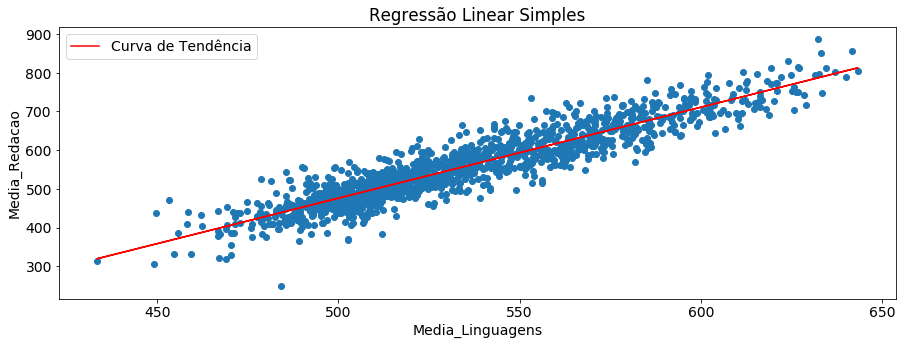

In [19]:
# Análise do Ano com uma das maiores notas em Redação em RJ, que foi onde a maior aconteceu
# Manja de português então soube escrever bem
xl = 'Media_Linguagens'
yl = 'Media_Redacao'
bs = base[(base['UF'] == 'RJ') & (base['Ano'] == 2014)].dropna(subset=[xl,yl],how='any')
x = bs[xl].astype('float')
y = bs[yl]
plt.figure(figsize=(15,5))
plt.rc('font', size=14) 
plt.scatter(x,y,label="")
b = regressaoLinear(x,y)
yp = resolveLin(b,x)
plt.plot(x,yp,'r',label="Curva de Tendência")
plt.title("Regressão Linear Simples")
plt.legend()
plt.xlabel(xl)
plt.ylabel(yl)
print('R2 = '+str(round(r2(y,yp)*100,2))+'%')
plt.show()

R2 = 77.63%


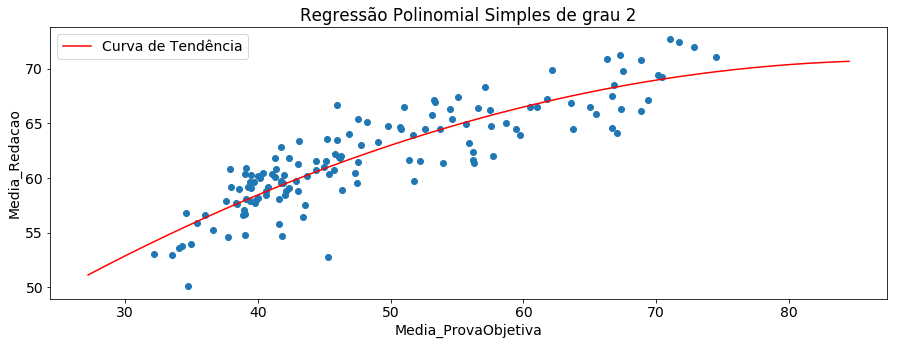

In [13]:
# Ano em que as questões do Enem não foram separado por grandes áreas
xl = 'Media_ProvaObjetiva'
yl = 'Media_Redacao'
bs = base[(base['Ano'] == 2008) & (base['UF'] == 'DF')].dropna(subset=[xl,yl],how='any')
x = bs[xl].astype('float')
y = bs[yl]
plt.figure(figsize=(15,5))
plt.rc('font', size=14) 
plt.scatter(x,y,label="")
x = np.array([x,x*x])
xplot = np.linspace(x.min()-5,x[0].max()+10,500)
xplot = np.array([xplot,xplot*xplot])
b = regressaoLinearMultipla(x,y)
yp = resolveLinVet(b,x.T)
yplot = resolveLinVet(b,xplot.T)
plt.plot(xplot[0],yplot,'r',label="Curva de Tendência")
plt.title("Regressão Polinomial Simples de grau 2")
plt.legend()
plt.xlabel(xl)
plt.ylabel(yl)
print('R2 = '+str(round(r2(y,yp)*100,2))+'%')
plt.show()

R2 = 82.37%


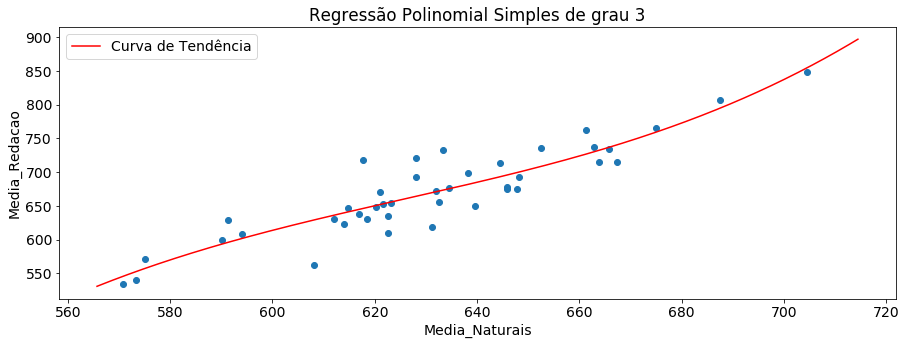

In [14]:
# Pessoal que quer medicina e tem dinheiro pra pagar cursinho
xl = 'Media_Naturais'
yl = 'Media_Redacao'
bs = base[(base['INSE'] == '6') & (base['UF'] == 'DF')].dropna(subset=[xl,yl],how='any')
x = bs[xl].astype('float')
y = bs[yl]
plt.figure(figsize=(15,5))
plt.rc('font', size=14) 
plt.scatter(x,y,label="")
x = np.array([x,x*x, x*x*x])
xplot = np.linspace(x.min()-5,x[0].max()+10,500)
xplot = np.array([xplot,xplot*xplot,xplot*xplot*xplot])
b = regressaoLinearMultipla(x,y)
yp = resolveLinVet(b,x.T)
yplot = resolveLinVet(b,xplot.T)
plt.plot(xplot[0],yplot,'r',label="Curva de Tendência")
plt.title("Regressão Polinomial Simples de grau 3")
plt.legend()
plt.xlabel(xl)
plt.ylabel(yl)
print('R2 = '+str(round(r2(y,yp)*100,2))+'%')
plt.show()

R2 = 90.09%


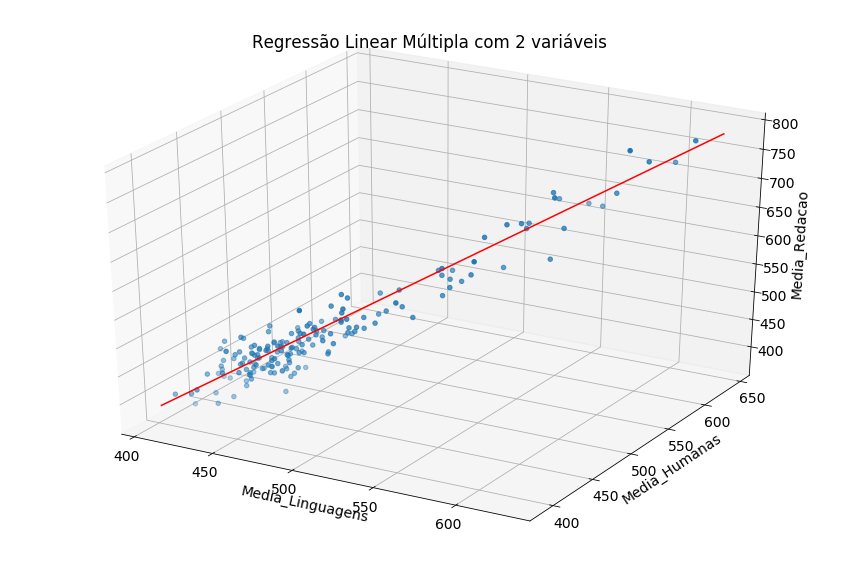

In [24]:
# Análise do Ano com as maiores notas em Tocantins, onde metade das notas é abaixo de 500 pontos
# Uma galera tirou nota baixa, mas quem ia bem nas mais subjetivas ia bem na redação
xl = 'Media_Linguagens'
yl = 'Media_Humanas'
zl = 'Media_Redacao'
b = base[(base['UF'] == 'TO') & (base['Ano'] == 2015)].dropna(subset=[xl,yl,zl,'Ano'],how='any')
x = b[xl]
y = b[yl]
z = b[zl]
xs = np.array([x,y])
b = regressaoLinearMultipla(xs,z)
zp = resolveLinVet(b,xs.T)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
print('R2 = '+str(round(r2(z,zp)*100,2))+'%')
plt.rc('font', size=14) 
ax.scatter(x,y,z)
xplot = np.linspace(x.min()-5,x.max()+10,500)
yplot = np.linspace(y.min()-5,y.max()+10,500)
xsplot = np.array([xplot,yplot])
zplot = resolveLinVet(b,xsplot.T)
ax.plot(xplot, yplot, zplot, color='r')
ax.set_zlabel(zl)
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title("Regressão Linear Múltipla com 2 variáveis")
plt.show()

R2 = 17.74%


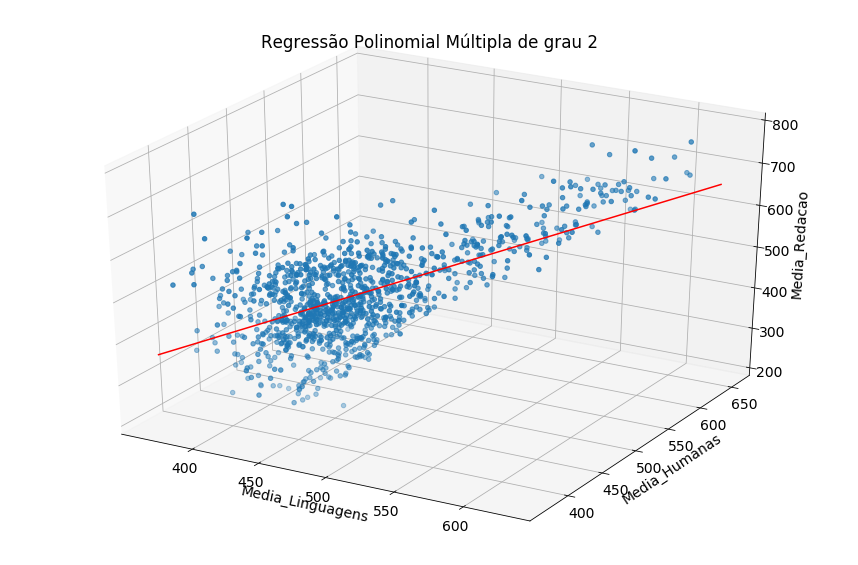

In [16]:
# Por fazer
xl = 'Media_Linguagens'
yl = 'Media_Humanas'
zl = 'Media_Redacao'
bs = base[(base['UF'] == 'TO')].dropna(subset=[xl,yl,zl],how='any')
x = bs[xl].astype('float')
y = bs[yl].astype('float')
z = bs[zl]

xs = np.array([x,x*x,y,y*y])
b = regressaoLinearMultipla(xs,y)
zp = resolveLinVet(b,xs.T)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)
xplot = np.linspace(x.min()-5,x.max()+10,500)
yplot = np.linspace(y.min()-5,y.max()+10,500)
xplot = np.array([xplot,xplot*xplot,yplot,yplot*yplot])
zplot = resolveLinVet(b,xplot.T)
ax.plot(xplot[0],xplot[2],zplot,'r')
ax.set_title("Regressão Polinomial Múltipla de grau 2")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)
print('R2 = '+str(round(r2(z,zp)*100,2))+'%')
plt.show()

R2 = 17.74%


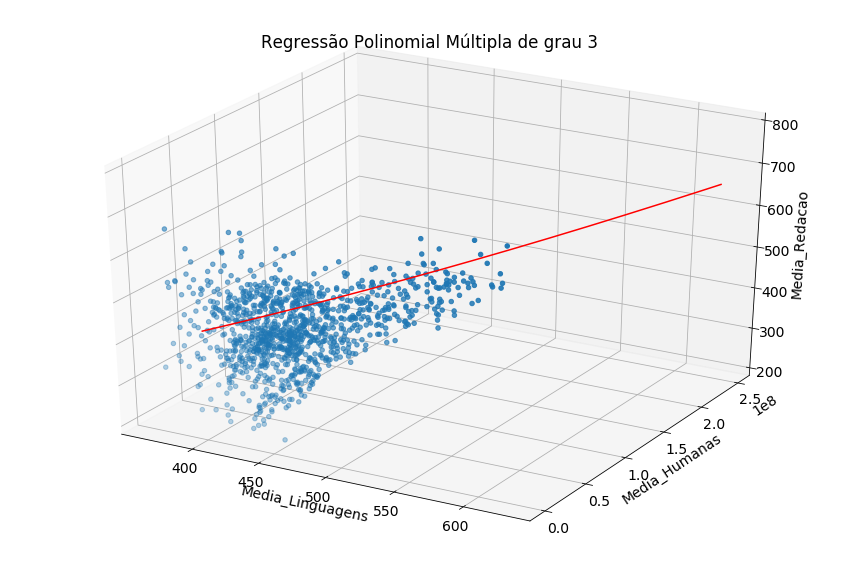

In [17]:
# Por fazer
xl = 'Media_Linguagens'
yl = 'Media_Humanas'
zl = 'Media_Redacao'
bs = base[(base['UF'] == 'TO')].dropna(subset=[xl,yl,zl],how='any')
x = bs[xl].astype('float')
y = bs[yl].astype('float')
z = bs[zl]

xs = np.array([x,x**2,x**3,y,y**2,y**3])
b = regressaoLinearMultipla(xs,y)
zp = resolveLinVet(b,xs.T)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)
xplot = np.linspace(x.min()-5,x.max()+10,500)
yplot = np.linspace(y.min()-5,y.max()+10,500)
xplot = np.array([xplot,xplot**2,xplot**3,yplot,yplot**2,yplot**3])
zplot = resolveLinVet(b,xplot.T)
ax.plot(xplot[0],xplot[2],zplot,'r')
ax.set_title("Regressão Polinomial Múltipla de grau 3")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)
print('R2 = '+str(round(r2(z,zp)*100,2))+'%')
plt.show()